In [105]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import logging
logging.getLogger().setLevel(logging.ERROR)

import jax
import jax.numpy as jnp
import numpyro.handlers as handlers
from numpyro.infer import Trace_ELBO

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../notebooks/matplotlibrc')

In [4]:
from models.poissonian import EbinPoissonModel

In [6]:
model = EbinPoissonModel(
    nfw_gamma=1.0,
    disk_option='fixed',
    dif_names = ['modelo'],
    blg_names = ['coleman2019'],
)

In [10]:
truth_dict = dict(
    S_iso = 0.3, S_psc = 0.5, S_bub = 0.2, S_dsk = 1.3, S_nfw = 1.0,
    S_pib = 10., S_ics = 6., S_blg = 0.2,
)

## 1. Simulate

In [72]:
def simulate(rng_key, model, ebin, td, preview=False, save_fn=None):
    assert len(model.dif_names) == 1
    assert len(model.blg_names) == 1
    assert model.nfw_gamma != 'vary'
    assert model.disk_option == 'fixed'

    mu = jnp.zeros_like(model.exposure[ebin])

    for k in ['iso', 'psc', 'bub', 'dsk', 'nfw']:
        mu += td[f'S_{k}'] * model.temps[k].at_bin(ebin)
    
    mu += td[f'S_pib'] * model.pib_temps[0].at_bin(ebin)
    mu += td[f'S_ics'] * model.ics_temps[0].at_bin(ebin)
    mu += td[f'S_blg'] * model.blg_temps[0].at_bin(ebin)

    counts = jax.random.poisson(rng_key, mu)

    if preview:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        plt.sca(axs[0])
        mask = model.normalization_mask
        vmin = 0.9
        vmax = np.max(mu[~mask])
        mu_plot = np.array(mu)
        mu_plot[mask] = np.nan
        hp.cartview(mu_plot, title='mu', latra=[-25, 25], lonra=[-25, 25], hold=True, norm='log', min=vmin, max=vmax)
        plt.sca(axs[1])
        counts_plot = np.array(counts, dtype=np.float32)
        counts_plot = np.clip(counts_plot, vmin, None)
        counts_plot[mask] = np.nan
        hp.cartview(counts_plot, title='counts', latra=[-25, 25], lonra=[-25, 25], hold=True, norm='log', min=vmin, max=vmax)

    if save_fn is not None:
        np.save(save_fn, np.array(counts))

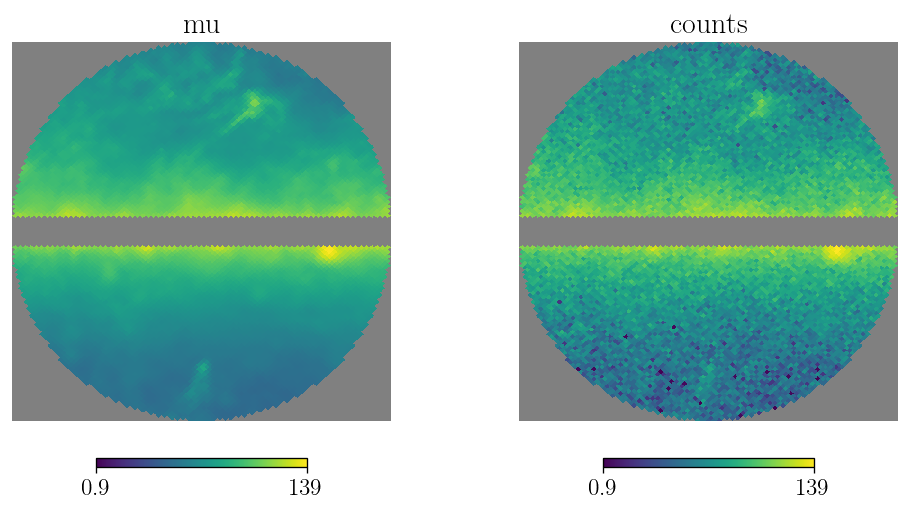

In [73]:
ebin = 10
simulate(jax.random.PRNGKey(42), model, ebin, truth_dict, preview=True)

In [ ]:
! mkdir ../outputs/validation

In [74]:
n_run = 100
save_dir = f'../outputs/validation/'

rng_key = jax.random.PRNGKey(42)
for i_run in tqdm(range(100)):
    rng_key, key = jax.random.split(rng_key)
    simulate(key, model, ebin, truth_dict, save_fn=f'{save_dir}/sim_ebin{ebin}_{i_run}.npy')

100%|██████████| 100/100 [00:04<00:00, 22.42it/s]


## 2. Do a single fit

In [95]:
def fit(rng_key, i_run, methods=['svi', 'nuts']):
    rng_key, key = jax.random.split(rng_key)
    counts = np.load(f'../outputs/validation/sim_ebin{ebin}_{i_run}.npy')

    model.counts[ebin] = counts
    model.config_model(ebin=ebin)
    
    if 'svi' in methods:
        rng_key, key = jax.random.split(rng_key)
        model.fit_SVI(key, guide='iaf', num_flows=5, hidden_dims=[256, 256],
                        n_steps=20000, lr=5e-5, num_particles=8, ebin=ebin)
        rng_key, key = jax.random.split(rng_key)
        samples = model.get_svi_samples(key, 50000)
        pickle.dump(samples, open(f"{save_dir}/svi_samples_{i_run}.p", "wb"))
        pickle.dump(model.svi_results, open(f"{save_dir}/svi_results_{i_run}.p", "wb"))

    if 'nuts' in methods:
        rng_key, key = jax.random.split(rng_key)
        mcmc = model.run_nuts(
            num_chains=4, num_warmup=500, num_samples=20000, step_size=0.01,
            rng_key=key, use_neutra=False, ebin=ebin
        )
        rng_key, key = jax.random.split(rng_key)
        pickle.dump(mcmc.get_samples(), open(f"{save_dir}/nuts_samples_{i_run}.p", "wb"))

In [ ]:
rng_key = jax.random.PRNGKey(42)
for i_run in range(1):
    rng_key, key = jax.random.split(rng_key)
    fit(key, i_run)

In [89]:
from utils.plotting import multi_corner

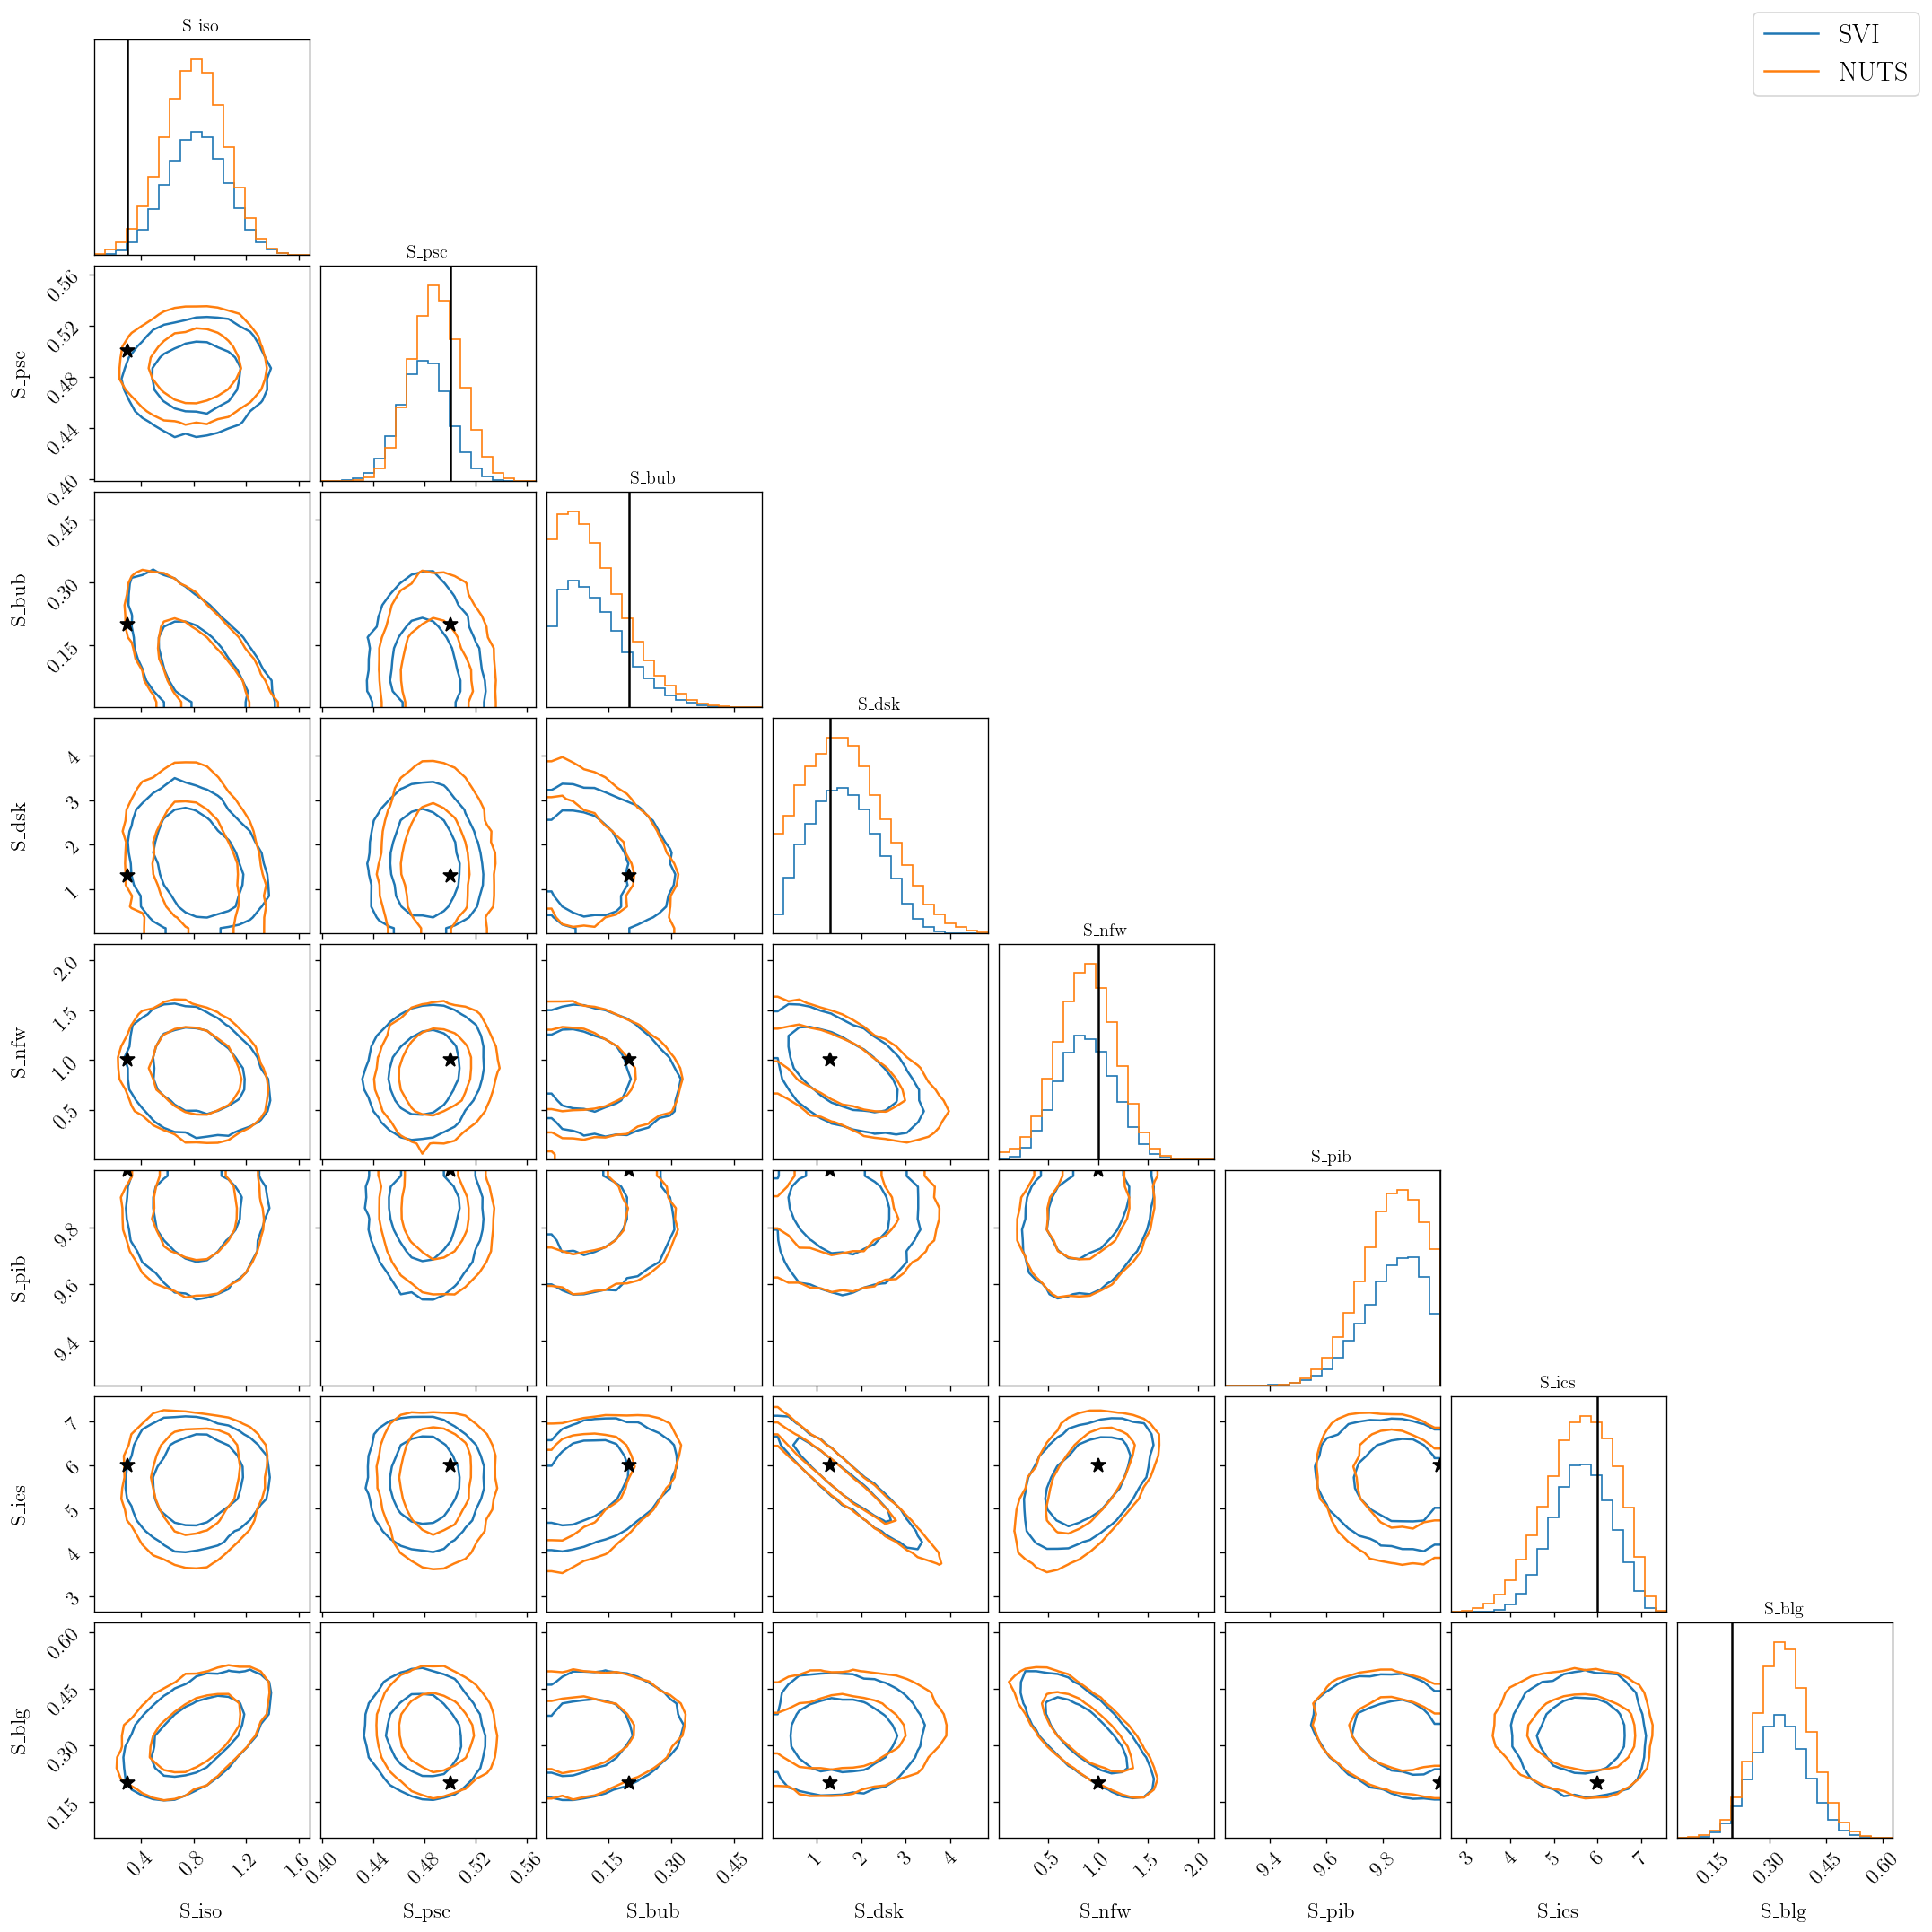

In [98]:
samples_dict = {
    'svi':  pickle.load(open(f"{save_dir}/svi_samples_0.p", "rb")),
    'nuts': pickle.load(open(f"{save_dir}/nuts_samples_0.p", "rb")),
}
colors_dict = {
    'svi':  'C0',
    'nuts': 'C1',
}
labels_dict = {
    'svi':  'SVI',
    'nuts': 'NUTS',
}
plot_var_names = ['S_iso', 'S_psc', 'S_bub', 'S_dsk', 'S_nfw', 'S_pib', 'S_ics', 'S_blg']
multi_corner(
    samples_dict, plot_var_names, MAP=truth_dict,
    colors_dict=colors_dict, labels_dict=labels_dict,
    n_bins_1d=30, save_fn=None
)

## 3. Do lots of fits

In [99]:
rng_key = jax.random.PRNGKey(42)
for i_run in range(1, 30):
    print(i_run, ':')
    rng_key, key = jax.random.split(rng_key)
    fit(key, i_run, ['svi'])

1 :


100%|██████████| 20000/20000 [00:22<00:00, 870.44it/s, init loss: 38085.3125, avg. loss [19001-20000]: 14906.7197] 


2 :


100%|██████████| 20000/20000 [00:23<00:00, 867.11it/s, init loss: 29736.8398, avg. loss [19001-20000]: 15005.6807] 


3 :


100%|██████████| 20000/20000 [00:23<00:00, 852.12it/s, init loss: 34901.8008, avg. loss [19001-20000]: 14867.1338] 


4 :


100%|██████████| 20000/20000 [00:22<00:00, 869.61it/s, init loss: 43085.7188, avg. loss [19001-20000]: 14886.0762] 


5 :


100%|██████████| 20000/20000 [00:22<00:00, 872.71it/s, init loss: 34229.0898, avg. loss [19001-20000]: 14844.1074] 


6 :


100%|██████████| 20000/20000 [00:22<00:00, 879.12it/s, init loss: 33690.7891, avg. loss [19001-20000]: 14933.0400] 


7 :


100%|██████████| 20000/20000 [00:23<00:00, 855.83it/s, init loss: 34153.1250, avg. loss [19001-20000]: 14887.1152] 


8 :


100%|██████████| 20000/20000 [00:22<00:00, 879.93it/s, init loss: 35766.3594, avg. loss [19001-20000]: 14923.8125] 


9 :


100%|██████████| 20000/20000 [00:22<00:00, 882.55it/s, init loss: 31838.2656, avg. loss [19001-20000]: 14854.0674] 


10 :


100%|██████████| 20000/20000 [00:22<00:00, 881.06it/s, init loss: 30193.9180, avg. loss [19001-20000]: 14985.3770] 


11 :


100%|██████████| 20000/20000 [00:22<00:00, 879.38it/s, init loss: 34041.0938, avg. loss [19001-20000]: 14935.2480] 


12 :


100%|██████████| 20000/20000 [00:23<00:00, 864.91it/s, init loss: 30071.4336, avg. loss [19001-20000]: 15020.4209] 


13 :


100%|██████████| 20000/20000 [00:22<00:00, 887.48it/s, init loss: 31990.6074, avg. loss [19001-20000]: 14871.5586] 


14 :


100%|██████████| 20000/20000 [00:22<00:00, 889.92it/s, init loss: 33917.2773, avg. loss [19001-20000]: 14988.8281] 


15 :


100%|██████████| 20000/20000 [00:23<00:00, 848.93it/s, init loss: 37772.1484, avg. loss [19001-20000]: 14935.7998] 


16 :


100%|██████████| 20000/20000 [00:23<00:00, 862.98it/s, init loss: 31759.0938, avg. loss [19001-20000]: 14910.9336] 


17 :


100%|██████████| 20000/20000 [00:22<00:00, 878.68it/s, init loss: 37645.7773, avg. loss [19001-20000]: 14883.1875] 


18 :


100%|██████████| 20000/20000 [00:23<00:00, 850.52it/s, init loss: 38572.7969, avg. loss [19001-20000]: 14817.4014] 


19 :


100%|██████████| 20000/20000 [00:22<00:00, 876.29it/s, init loss: 35654.5781, avg. loss [19001-20000]: 14871.9404] 


20 :


100%|██████████| 20000/20000 [00:23<00:00, 861.60it/s, init loss: 36827.9062, avg. loss [19001-20000]: 14883.8984] 


21 :


100%|██████████| 20000/20000 [00:22<00:00, 897.33it/s, init loss: 33086.9531, avg. loss [19001-20000]: 14907.7090] 


22 :


100%|██████████| 20000/20000 [00:22<00:00, 886.02it/s, init loss: 31864.0078, avg. loss [19001-20000]: 14940.3730] 


23 :


100%|██████████| 20000/20000 [00:23<00:00, 863.10it/s, init loss: 35780.2734, avg. loss [19001-20000]: 14994.9990] 


24 :


100%|██████████| 20000/20000 [00:22<00:00, 877.79it/s, init loss: 29008.4688, avg. loss [19001-20000]: 14881.0068] 


25 :


100%|██████████| 20000/20000 [00:23<00:00, 855.46it/s, init loss: 37325.6523, avg. loss [19001-20000]: 14863.8965] 


26 :


100%|██████████| 20000/20000 [00:22<00:00, 870.77it/s, init loss: 36948.5703, avg. loss [19001-20000]: 14866.2266] 


27 :


100%|██████████| 20000/20000 [00:22<00:00, 887.52it/s, init loss: 32692.7969, avg. loss [19001-20000]: 14856.2949] 


28 :


100%|██████████| 20000/20000 [00:22<00:00, 873.33it/s, init loss: 38260.8672, avg. loss [19001-20000]: 15042.4561] 


29 :


100%|██████████| 20000/20000 [00:23<00:00, 867.05it/s, init loss: 38746.6641, avg. loss [19001-20000]: 14923.9434] 


In [100]:
from utils.validation import find_hdi_prob, roc_finite_sample_band

In [101]:
samples_fn_list = [f for f in os.listdir(save_dir) if f.startswith("svi_samples")]
n_actual_run = len(samples_fn_list)

roc_runs = {k : [] for k in truth_dict.keys()}
for samples_fn in tqdm(samples_fn_list):
    samples = pickle.load(open(f"{save_dir}/{samples_fn}", "rb"))
    for k, v in truth_dict.items():
        samples_k = np.array(samples[k])
        roc_runs[k].append(find_hdi_prob(samples_k, v, level=15))
for k in roc_runs.keys():
    roc_runs[k] = np.sort(roc_runs[k])

100%|██████████| 30/30 [00:01<00:00, 15.06it/s]


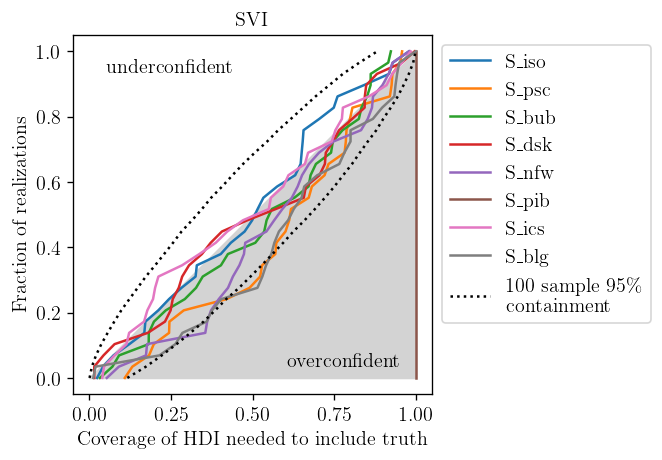

In [106]:
invcdf_lower, invcdf_upper = roc_finite_sample_band(n_actual_run)

fig, ax = plt.subplots()

view_keys = ['S_iso', 'S_psc', 'S_bub', 'S_dsk', 'S_nfw', 'S_pib', 'S_ics', 'S_blg']

linestyles = ['-', '--', ':', '-.']

ax.fill_between([0,1], [0,1], color='lightgray')
for i, (k, roc) in enumerate(roc_runs.items()):
    if k in view_keys:
        ax.plot(roc, np.linspace(0, 1, n_actual_run), label=k, color=f'C{i%10}', linestyle=linestyles[i//10])

ax.plot(invcdf_upper, np.linspace(0, 1, n_actual_run), 'k:', label=f'{n_run} sample 95\% \ncontainment')
ax.plot(invcdf_lower, np.linspace(0, 1, n_actual_run), 'k:')

ax.set(aspect=1)
ax.set(xlabel='Coverage of HDI needed to include truth', ylabel='Fraction of realizations',
       title=f'SVI')
ax.text(0.95, 0.05, 'overconfident', ha='right', va='center')
ax.text(0.05, 0.95, 'underconfident', ha='left', va='center')

fig.legend(bbox_to_anchor=(1, 1), loc='upper left', bbox_transform=ax.transAxes)
plt.tight_layout()
#plt.savefig(f"fit_np_to_p/roc.pdf")

100%|██████████| 30/30 [00:00<00:00, 31.66it/s]


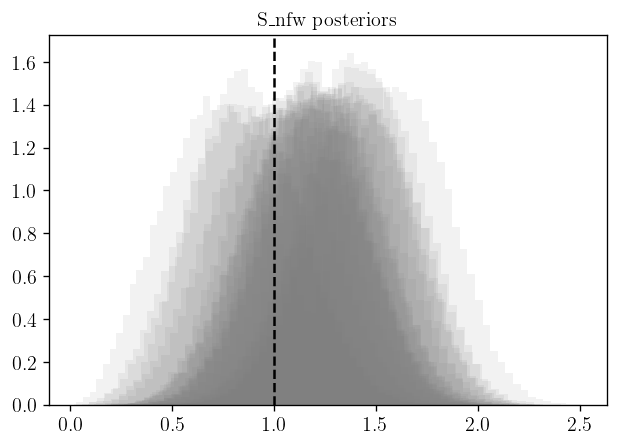

In [107]:
fig, ax = plt.subplots()

k = 'S_nfw'

for samples_fn in tqdm(samples_fn_list):
    svi_samples = pickle.load(open(f'{save_dir}/{samples_fn}', 'rb'))
    ax.hist(np.array(svi_samples[k]), density=True, alpha=0.1, bins=50, color='gray')
ax.set(title=f'{k} posteriors')
ax.axvline(truth_dict[k], color='k', linestyle='--')